**# Lab3 - AI - Convolutional Neural networks from Scratch and Fine Tuning**



In [ ]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
np.random.seed(7)
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## PART 1: **BUILD A CNN MODEL FROM SCRATCH**


In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [
        transforms.Resize(32),
         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
     
     ]
     
     )

# transform_valid = transforms.Compose(
#     [
#         # transforms.Resize(256),
#         # transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     
#      ]
     
#      )

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

Train size :  50000
validation size :  10000


In [ ]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) 
print(labels.shape) 

torch.Size([64, 3, 32, 32])
torch.Size([64])


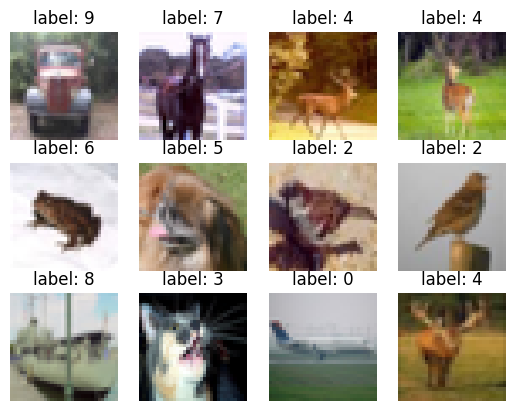

In [ ]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off') 
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_cifar(nn.Module):
    def __init__(self):
        super(CNN_cifar, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5,stride=1, padding=2),
            # nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 5,1,2),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 128,5,1,2),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256,5,1,2),
            # nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )
        
        # Ajustement pour les dimensions d'entrée CIFAR-10 (32x32)
        self.classifier = nn.Sequential(         
            nn.Linear(256 * 2 * 2, 4096),  # Mise à jour ici
            nn.ReLU(inplace=True),           
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),  # CIFAR-10 a 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Exemple d'instanciation et impression de l'architecture du modèle
model = CNN_cifar()
print(model)


CNN_cifar(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU(inplace=T

In [49]:
model = CNN_cifar()
model.to(device)
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

22098762


In [50]:
optimizer = optim.SGD(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

**Ajout d'une fonction "Early Stopping permettant de prevenir l'overfiting Si la perte de validation ne s'améliore pas pendant un nombre spécifié d'époques (patience)**

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True, delta=0.001): 

        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} sur {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialisation de l'early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [ ]:
import time
epochs = 60
train_loss = []
val_loss = []
accuracy_total_train = []
accuracy_total_val = []

for epoch in range(epochs):
    start_time = time.time()  
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    total = 0


    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = F.softmax(pred, dim=1)
        total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_train = total / len(trainLoader.dataset)
    accuracy_total_train.append(accuracy_train)
    total_train_loss /= (idx + 1)
    train_loss.append(total_train_loss)


    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()
        pred = F.softmax(pred, dim=1)
        total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_val = total / len(validationLoader.dataset)
    accuracy_total_val.append(accuracy_val)
    total_val_loss /= (idx + 1)
    val_loss.append(total_val_loss)
    epoch_time = time.time() - start_time  

    print(f"Epoch: {epoch+1}/{epochs}  "
          f"Training loss: {total_train_loss:.4f}  "
          f"Validation loss: {total_val_loss:.4f}  "
          f"Train accuracy: {accuracy_train:.4f}  "
          f"Validation accuracy: {accuracy_val:.4f}"
          f"Time: {epoch_time:.2f}s")

    early_stopping(total_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch: 1/60  Training loss: 2.3023  Validation loss: 2.3018  Train accuracy: 0.1015  Validation accuracy: 0.1020Time: 13.53s
Epoch: 2/60  Training loss: 2.3014  Validation loss: 2.3009  Train accuracy: 0.1363  Validation accuracy: 0.1554Time: 13.41s
EarlyStopping counter: 1 sur 5
Epoch: 3/60  Training loss: 2.3004  Validation loss: 2.2997  Train accuracy: 0.1393  Validation accuracy: 0.1290Time: 13.70s
Epoch: 4/60  Training loss: 2.2989  Validation loss: 2.2977  Train accuracy: 0.1310  Validation accuracy: 0.1158Time: 13.36s
Epoch: 5/60  Training loss: 2.2962  Validation loss: 2.2940  Train accuracy: 0.1203  Validation accuracy: 0.1371Time: 13.36s
Epoch: 6/60  Training loss: 2.2904  Validation loss: 2.2844  Train accuracy: 0.1540  Validation accuracy: 0.1682Time: 13.39s
Epoch: 7/60  Training loss: 2.2736  Validation loss: 2.2565  Train accuracy: 0.1712  Validation accuracy: 0.1655Time: 13.47s
Epoch: 8/60  Training loss: 2.2377  Validation loss: 2.2115  Train accuracy: 0.1815  Validatio

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

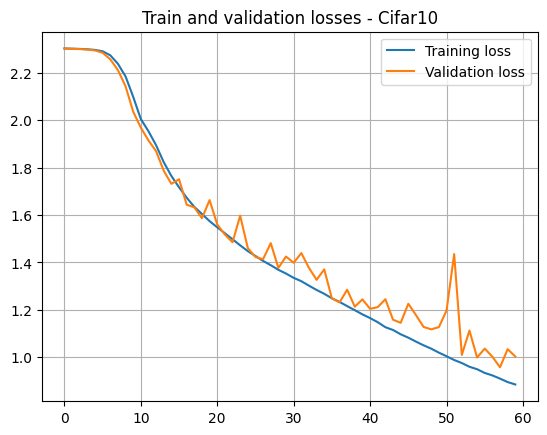

In [53]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

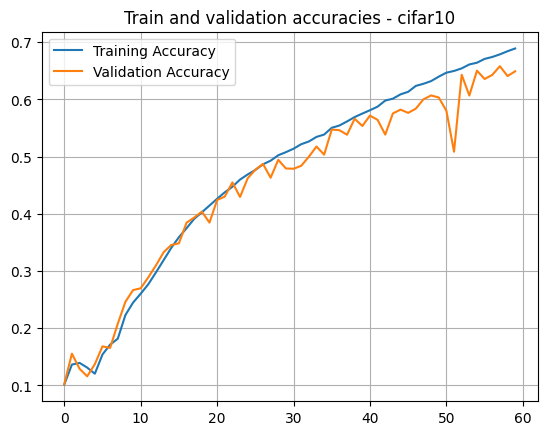

In [54]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

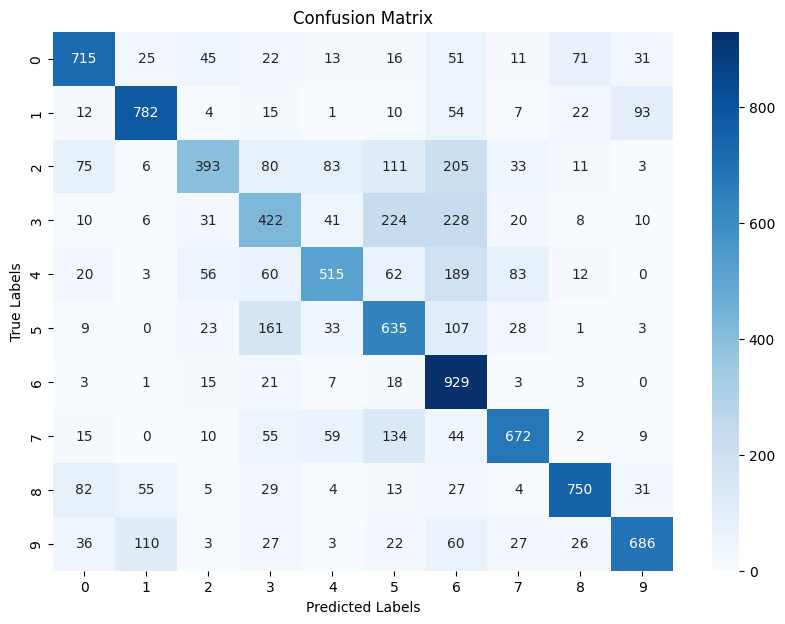

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def get_all_preds_labels(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels


preds, labels = get_all_preds_labels(model, validationLoader)

# Confusion Matrix
conf_mat = confusion_matrix(labels, preds)

# Plot the confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## **PART 2**: **FINE TUNING WITH RESNET18**

**TIMM**,  popular library open-source library for PyTorch that provides a wide range of pre-trained deep learning models for image classification, segmentation, and other computer vision tasks

In [13]:
! pip install timm

In [15]:
import timm
from torch import nn

In [ ]:
import torch
from torchvision import datasets, transforms
transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

     ]

     )

train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [58]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.res_net = timm.create_model('resnet18', pretrained=True, num_classes=10)

    def forward(self, images, labels=None):
        logits = self.res_net(images)
        return logits

In [ ]:
model1 = Model()
model1.to(device)

Model(
  (res_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

**Visualizationi of parameter number of ResNet 18**

In [60]:
total_trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(total_trainable_params )

11181642


**Initialization of the Optimizer**

In [ ]:
optimizer = optim.SGD(model1.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 60
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):
    start_time = time.time()  
    
    total_train_loss = 0
    total_val_loss = 0

    model1.train()

    total = 0

    # Training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model1(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = F.softmax(pred, dim=1)
        total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_train = total / len(trainLoader.dataset)
    accuracy_total_train.append(accuracy_train)

    total_train_loss /= len(trainLoader)
    train_loss.append(total_train_loss)

    # Validating our model
    model1.eval()
    total = 0
    with torch.no_grad():
        for idx, (image, label) in enumerate(validationLoader):
            image, label = image.to(device), label.to(device)
            pred = model1(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            pred = F.softmax(pred, dim=1)
            total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_val = total / len(validationLoader.dataset)
    accuracy_total_val.append(accuracy_val)

    total_val_loss /= len(validationLoader)
    val_loss.append(total_val_loss)

    epoch_time = time.time() - start_time  

    print(f"Epoch: {epoch+1}/{epochs}  "
          f"Training loss: {total_train_loss:.4f}  "
          f"Validation loss: {total_val_loss:.4f}  "
          f"Train accuracy: {accuracy_train:.4f}  "
          f"Validation accuracy: {accuracy_val:.4f}  "
          f"Time: {epoch_time:.2f}s")

Epoch: 1/60  Training loss: 2.2543  Validation loss: 2.1962  Train accuracy: 0.1861  Validation accuracy: 0.2729  Time: 149.78s
Epoch: 2/60  Training loss: 2.1383  Validation loss: 2.0860  Train accuracy: 0.3185  Validation accuracy: 0.3460  Time: 146.77s
Epoch: 3/60  Training loss: 2.0157  Validation loss: 1.9811  Train accuracy: 0.3672  Validation accuracy: 0.3892  Time: 146.72s
Epoch: 4/60  Training loss: 1.8967  Validation loss: 1.8505  Train accuracy: 0.4055  Validation accuracy: 0.4138  Time: 148.73s
Epoch: 5/60  Training loss: 1.7944  Validation loss: 1.7390  Train accuracy: 0.4276  Validation accuracy: 0.4463  Time: 159.06s
Epoch: 6/60  Training loss: 1.6913  Validation loss: 1.6571  Train accuracy: 0.4584  Validation accuracy: 0.4663  Time: 160.57s
Epoch: 7/60  Training loss: 1.5992  Validation loss: 1.5519  Train accuracy: 0.4793  Validation accuracy: 0.4928  Time: 164.66s
Epoch: 8/60  Training loss: 1.5159  Validation loss: 1.4610  Train accuracy: 0.5029  Validation accuracy

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

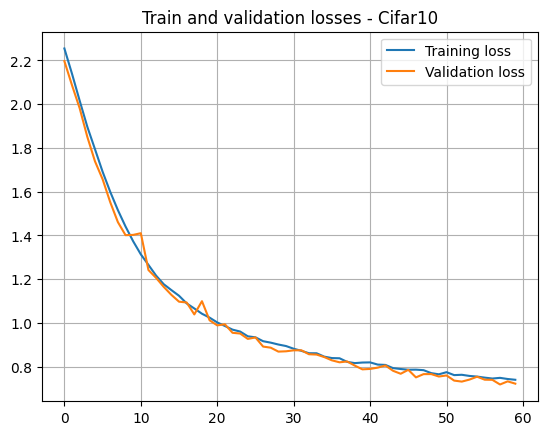

In [63]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

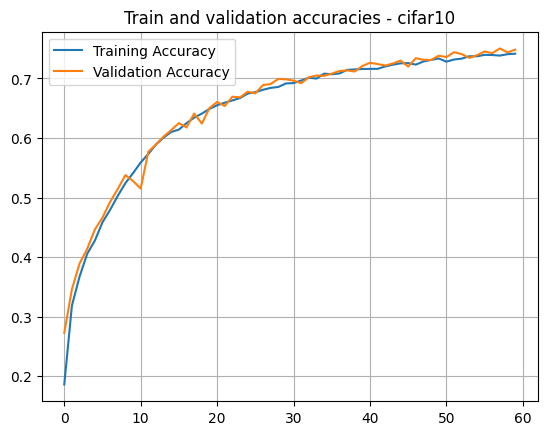

In [64]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

**FEATURE EXTRACTOR RESNET18**

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [ ]:
model_Ex = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_Ex.parameters():
    param.requires_grad = False

num_ftrs = model_Ex.fc.in_features
model_Ex.fc = nn.Linear(num_ftrs, 10)

Extractor = model_Ex.to(device)
print(Extractor)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
total_trainable_params = sum(p.numel() for p in Extractor.parameters() if p.requires_grad)
print(total_trainable_params )

5130


In [71]:
optimizer = optim.SGD(Extractor.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 60
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):
    start_time = time.time()  
    
    total_train_loss = 0
    total_val_loss = 0

    Extractor.train()

    total = 0

    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = Extractor(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = F.softmax(pred, dim=1)
        total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_train = total / len(trainLoader.dataset)
    accuracy_total_train.append(accuracy_train)

    total_train_loss /= len(trainLoader)
    train_loss.append(total_train_loss)

    # Validating our model
    Extractor.eval()
    total = 0
    with torch.no_grad():
        for idx, (image, label) in enumerate(validationLoader):
            image, label = image.to(device), label.to(device)
            pred = Extractor(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            pred = F.softmax(pred, dim=1)
            total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_val = total / len(validationLoader.dataset)
    accuracy_total_val.append(accuracy_val)

    total_val_loss /= len(validationLoader)
    val_loss.append(total_val_loss)


    epoch_time = time.time() - start_time  # End time of the epoch

    print(f"Epoch: {epoch+1}/{epochs}  "
          f"Training loss: {total_train_loss:.4f}  "
          f"Validation loss: {total_val_loss:.4f}  "
          f"Train accuracy: {accuracy_train:.4f}  "
          f"Validation accuracy: {accuracy_val:.4f}  "
          f"Time: {epoch_time:.2f}s")

Epoch: 1/60  Training loss: 2.0299  Validation loss: 1.7868  Train accuracy: 0.2912  Validation accuracy: 0.4158  Time: 84.57s
Epoch: 2/60  Training loss: 1.6751  Validation loss: 1.5564  Train accuracy: 0.4563  Validation accuracy: 0.5070  Time: 81.33s
Epoch: 3/60  Training loss: 1.5165  Validation loss: 1.4452  Train accuracy: 0.5084  Validation accuracy: 0.5344  Time: 81.13s
Epoch: 4/60  Training loss: 1.4320  Validation loss: 1.3864  Train accuracy: 0.5302  Validation accuracy: 0.5428  Time: 83.20s
Epoch: 5/60  Training loss: 1.3705  Validation loss: 1.3349  Train accuracy: 0.5465  Validation accuracy: 0.5559  Time: 82.43s
Epoch: 6/60  Training loss: 1.3362  Validation loss: 1.2972  Train accuracy: 0.5530  Validation accuracy: 0.5641  Time: 81.41s
Epoch: 7/60  Training loss: 1.3061  Validation loss: 1.2718  Train accuracy: 0.5593  Validation accuracy: 0.5729  Time: 86.56s
Epoch: 8/60  Training loss: 1.2875  Validation loss: 1.2529  Train accuracy: 0.5643  Validation accuracy: 0.577

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

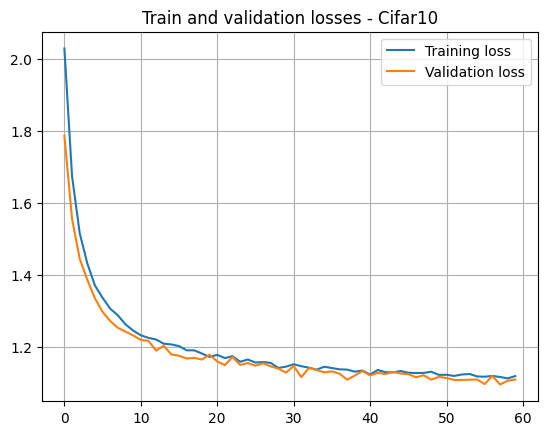

In [74]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

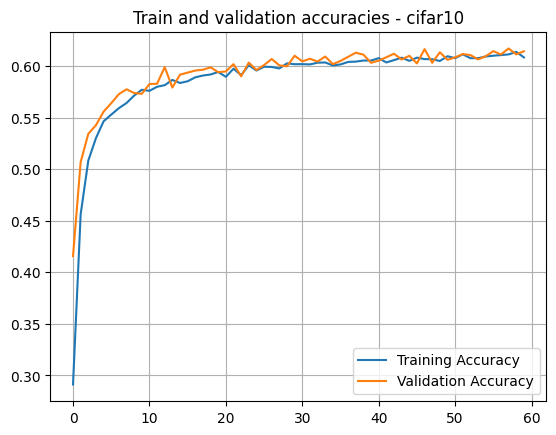

In [75]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

# **PART 3**: **FEATURE EXTRACTOR SQUEZZNET**

In [76]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. You have", torch.cuda.device_count(), "GPU(s).")
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available. You have 1 GPU(s).
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [88]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import time

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model_squeez = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
model_squeez = model_squeez.to(device)  

for param in model_squeez.parameters():
    param.requires_grad = False

for param in model_squeez.parameters():
    param.requires_grad = False

model_squeez.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
model_squeez.num_classes = 10

Using cache found in C:\Users\Obed/.cache\torch\hub\pytorch_vision_v0.10.0


In [93]:
model_squeez = model_squeez.to(device)

In [ ]:
total_trainable_params = sum(p.numel() for p in model_squeez.parameters() if p.requires_grad)
print(total_trainable_params )

5130


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_squeez.classifier.parameters(), lr=0.001)

print(model_squeez)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:

epochs = 60
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):
    start_time = time.time()  
    
    total_train_loss = 0
    total_val_loss = 0

    model_squeez.train()

    total = 0


    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)  

        optimizer.zero_grad()

        pred = model_squeez(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = F.softmax(pred, dim=1)
        total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_train = total / len(trainLoader.dataset)
    accuracy_total_train.append(accuracy_train)

    total_train_loss /= len(trainLoader)
    train_loss.append(total_train_loss)


    model_squeez.eval()
    total = 0
    with torch.no_grad():
        for idx, (image, label) in enumerate(validationLoader):
            image, label = image.to(device), label.to(device)  
            pred = model_squeez(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            pred = F.softmax(pred, dim=1)
            total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_val = total / len(validationLoader.dataset)
    accuracy_total_val.append(accuracy_val)

    total_val_loss /= len(validationLoader)
    val_loss.append(total_val_loss)

    epoch_time = time.time() - start_time  
    
    print(f"Époque: {epoch+1}/{epochs}  "
          f"Perte d'entraînement: {total_train_loss:.4f}  "
          f"Perte de validation: {total_val_loss:.4f}  "
          f"Précision d'entraînement: {accuracy_train:.4f}  "
          f"Précision de validation: {accuracy_val:.4f}  "
          f"Temps: {epoch_time:.2f}s")

Époque: 1/60  Perte d'entraînement: 1.6981  Perte de validation: 1.3913  Précision d'entraînement: 0.3956  Précision de validation: 0.5054  Temps: 83.31s
Époque: 2/60  Perte d'entraînement: 1.3416  Perte de validation: 1.2679  Précision d'entraînement: 0.5242  Précision de validation: 0.5510  Temps: 84.54s
Époque: 3/60  Perte d'entraînement: 1.2474  Perte de validation: 1.2027  Précision d'entraînement: 0.5570  Précision de validation: 0.5721  Temps: 87.32s
Époque: 4/60  Perte d'entraînement: 1.1973  Perte de validation: 1.1806  Précision d'entraînement: 0.5787  Précision de validation: 0.5796  Temps: 90.20s
Époque: 5/60  Perte d'entraînement: 1.1651  Perte de validation: 1.1300  Précision d'entraînement: 0.5893  Précision de validation: 0.6070  Temps: 90.96s
Époque: 6/60  Perte d'entraînement: 1.1360  Perte de validation: 1.1123  Précision d'entraînement: 0.6009  Précision de validation: 0.6043  Temps: 90.06s
Époque: 7/60  Perte d'entraînement: 1.1126  Perte de validation: 1.0934  Pré

Text(0.5, 1.0, "Précisions d'entraînement et de validation - CIFAR10")

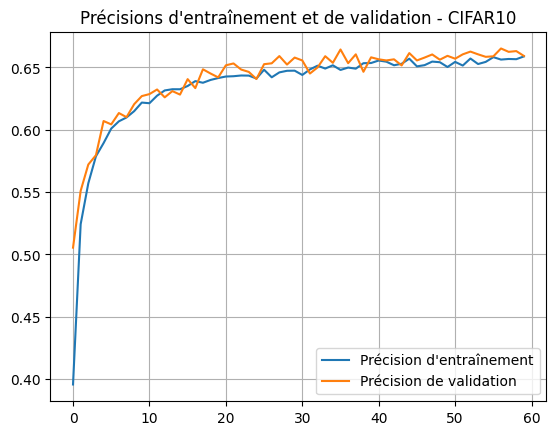

In [ ]:
plt.plot(accuracy_total_train, label='Précision d\'entraînement')
plt.plot(accuracy_total_val, label='Précision de validation')
plt.legend()
plt.grid()
plt.title('Précisions d\'entraînement et de validation - CIFAR10')

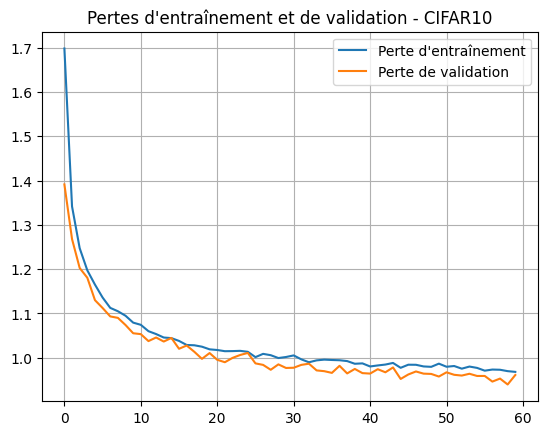

In [ ]:
plt.plot(train_loss, label='Perte d\'entraînement')
plt.plot(val_loss, label='Perte de validation')
plt.legend()
plt.grid()
plt.title('Pertes d\'entraînement et de validation - CIFAR10')
plt.show()

**MODEL SQUEEZNET FINETUNING**

In [22]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. You have", torch.cuda.device_count(), "GPU(s).")
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available. You have 1 GPU(s).
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import time


transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

# Load the pre-trained SqueezeNet model
model_squeezFT = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
model_squeezFT = model_squeez.to(device)  

print(model_squeezFT)


Files already downloaded and verified
Files already downloaded and verified
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

Using cache found in C:\Users\Obed/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Obed\.conda\envs\torchenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Obed\.conda\envs\torchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
total_trainable_params = sum(p.numel() for p in model_squeezFT.parameters() if p.requires_grad)
print(total_trainable_params )

1248424


In [ ]:
optimizer = optim.SGD(model_squeezFT.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [ ]:

epochs = 60
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):
    start_time = time.time()  
    
    total_train_loss = 0
    total_val_loss = 0

    model_squeezFT.train()

    total = 0

    # Training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)  

        optimizer.zero_grad()

        pred = model_squeezFT(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = F.softmax(pred, dim=1)
        total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_train = total / len(trainLoader.dataset)
    accuracy_total_train.append(accuracy_train)

    total_train_loss /= len(trainLoader)
    train_loss.append(total_train_loss)

    
    model_squeezFT.eval()
    total = 0
    with torch.no_grad():
        for idx, (image, label) in enumerate(validationLoader):
            image, label = image.to(device), label.to(device)  #
            pred = model_squeezFT(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            pred = F.softmax(pred, dim=1)
            total += (pred.argmax(dim=1) == label).sum().item()

    accuracy_val = total / len(validationLoader.dataset)
    accuracy_total_val.append(accuracy_val)

    total_val_loss /= len(validationLoader)
    val_loss.append(total_val_loss)

    epoch_time = time.time() - start_time  

    print(f"Epoch: {epoch+1}/{epochs}  "
          f"Training loss: {total_train_loss:.4f}  "
          f"Validation loss: {total_val_loss:.4f}  "
          f"Train accuracy: {accuracy_train:.4f}  "
          f"Validation accuracy: {accuracy_val:.4f}  "
          f"Time: {epoch_time:.2f}s")


Epoch: 1/60  Training loss: 1.7054  Validation loss: 1.3966  Train accuracy: 0.3898  Validation accuracy: 0.5003  Time: 208.34s
Epoch: 2/60  Training loss: 1.3045  Validation loss: 1.2684  Train accuracy: 0.5351  Validation accuracy: 0.5426  Time: 203.47s
Epoch: 3/60  Training loss: 1.1623  Validation loss: 1.7223  Train accuracy: 0.5866  Validation accuracy: 0.4409  Time: 204.08s
Epoch: 4/60  Training loss: 1.0743  Validation loss: 1.1748  Train accuracy: 0.6211  Validation accuracy: 0.5953  Time: 205.79s
Epoch: 5/60  Training loss: 1.0227  Validation loss: 1.2589  Train accuracy: 0.6370  Validation accuracy: 0.5733  Time: 206.17s
Epoch: 6/60  Training loss: 0.9774  Validation loss: 1.0362  Train accuracy: 0.6548  Validation accuracy: 0.6284  Time: 163.65s
Epoch: 7/60  Training loss: 0.9452  Validation loss: 0.9660  Train accuracy: 0.6668  Validation accuracy: 0.6581  Time: 150.01s
Epoch: 8/60  Training loss: 0.9184  Validation loss: 0.9260  Train accuracy: 0.6759  Validation accuracy

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

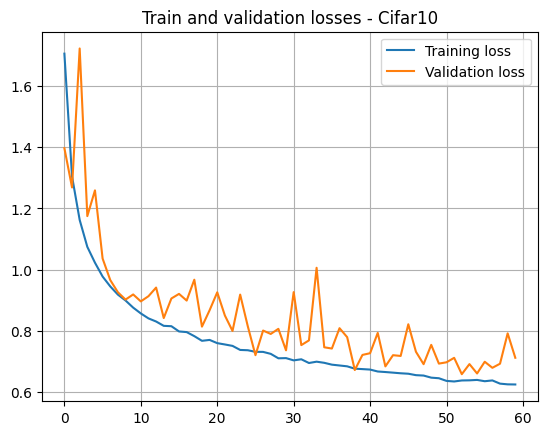

In [31]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

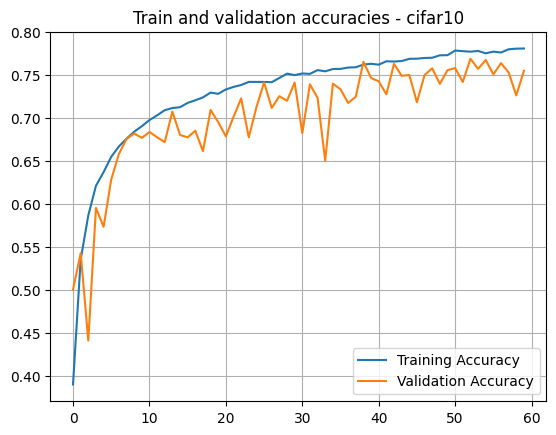

In [32]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

Tous le travail a été fait sur une machine **Lenovo AMD Ryzen 9 7945HX, 2.5ghz min 32 CPU GPU: NVIDIA GeForce RTX 4060 Laptop GPU**

# Résultats des modèles

| *Model Number*        | *Trainable params* | *Test accuracy* | *Training time per epoch* |
|-------------------------|----------------------|-------------------|-----------------------------|
| From scratch            | 22098762             |Train accuracy:68.91 %;  Val accuracy:64.92 %            | 13.085 seconds;   30 epochs |
| RESNET18 (feat_extract)     | 5,130           |Train accuracy: 60.85 %  Val accuracy:61.45 %                | 84.98 seconds;  60 epochs                  | 
| RESNET18 (finetuning)       | 11,181,642           |Train accuracy: 74.15%;  Val accuracy: 74.83 %  | 164.37 seconds;   60 epochs                   |
| SQUEZZNET (feat_extract)     | 5,130            |Train accuracy:65.88 %;  Val accuracy: 65.92 %             | 90.86 seconds; 60 epochs                  |
| SQUEZZNET (finetuning)       | 1,248,424           | Train accuracy:78.09 %  Val accuracy:75.50 %             | 162.73 seconds; 60 epochs                  |